# Chapter-3 ONNX integration with Deep Learning frameworks

#### In this notebook, we will learn to convert Pytorch, Tensorflow and Scikit-learn model into ONNX model. The execution of the exported model is already covered in notebook-2.

## Part-1 : Pytorch to ONNX conversion

### 1.1 Pytorch model loading and execution

In [1]:
# Note: Please make sure the notebook-2 python dependencies are also installed in the environment.

# Install pytorch prerequisites
!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cpu
!pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
# Download a sample image for the inference.
!wget https://huggingface.co/spaces/ClassCat/ViT-ImageNet-Classification/resolve/main/samples/cat.jpg

--2025-01-26 16:20:34--  https://huggingface.co/spaces/ClassCat/ViT-ImageNet-Classification/resolve/main/samples/cat.jpg
13.33.146.59, 13.33.146.97, 13.33.146.86, ...
Connecting to huggingface.co (huggingface.co)|13.33.146.59|:443... connected.
200 OKequest sent, awaiting response... 
Length: 5792 (5.7K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   5.66K  --.-KB/s    in 0s      

2025-01-26 16:20:35 (1.70 GB/s) - ‘cat.jpg’ saved [5792/5792]



In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

# Load the pre-trained ResNet-50 model
# model = models.resnet50(pretrained=True)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Set the model to evaluation mode (this disables dropout and batch normalization layers)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# Define image transform (preprocessing)
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop to 224x224 (ResNet input size)
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with the same stats as the training data
])

# Function to load image from a URL
def load_image(image_path):
    if image_path.startswith('http'):
        response = requests.get(image_path, stream=True)
        img = Image.open(response.raw)
    else:
        img = Image.open(image_path)
    return img

# Inference function
def infer_image(image_path):
    # Load and preprocess the image
    image = load_image(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)
    
    # Move image to the appropriate device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)
    
    # Perform inference
    with torch.no_grad():
        logits = model(image)
        probs = torch.nn.functional.softmax(logits)

    # Get the predicted class
    predicted_prob, predicted_class = probs.max(1)
    
    # Load the ImageNet class labels
    LABELS_URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
    response = requests.get(LABELS_URL)
    class_idx = response.json()
    
    # Map predicted class index to label
    predicted_label = class_idx[str(predicted_class.item())][1]
    
    return predicted_prob[0], predicted_label

/tmp/ipykernel_189922/202236731.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


Predicted label: tiger_cat, Confidence score: 0.41


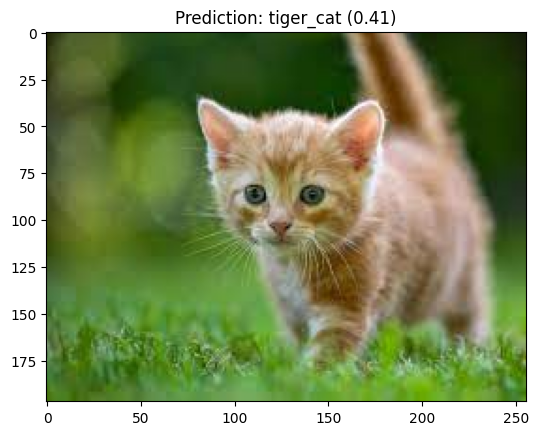

In [5]:
# Example usage
image_path = 'cat.jpg'  # Change this to the path of your image
probability, class_label = infer_image(image_path)

print(f"Predicted label: {class_label}, Confidence score: {probability:.2f}")

# Optionally, display the image and the prediction
image = load_image(image_path)
plt.imshow(image)
plt.title(f"Prediction: {class_label} ({probability:.2f})")
plt.show()

### 1.2 Pytorch to ONNX model conversion

In [6]:
# To convert any pytorch module, we can use below API.
# Documentation: https://pytorch.org/docs/stable/onnx_torchscript.html#torch.onnx.export

import os
os.makedirs("./exported_models/torch/", exist_ok=True)
output_path = "./exported_models/torch/resnet50_torch.onnx"

dummy_input = torch.randn(1, 3, 224, 224, dtype=torch.float32)

torch.onnx.export(
    model, 
    (dummy_input,),
    output_path, 
    input_names=["input"],
    output_names=["logits"],
)

print(f"ONNX model has been saved to {output_path}")

ONNX model has been saved to ./exported_models/torch/resnet18_torch.onnx


In [7]:
!ls -lrth exported_models/torch/

total 98M
-rwxrwxrwx 1 meet meet 98M Jan 26 16:21 resnet18_torch.onnx


In [8]:
import IPython
import netron

port = 6006
netron.start(output_path, port, browse=False)
IPython.display.IFrame(f"http://localhost:{port}", width=1000, height=500)

Serving './exported_models/torch/resnet18_torch.onnx' at http://localhost:6006


## Part-2: Tensorflow to ONNX Conversion

### 2.1 Tensorflow model loading and execution

In [9]:
# Install tensorflow dependencies
!pip install tensorflow tf2onnx

In [10]:
import tensorflow as tf
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained ResNet-18 model from TensorFlow Keras Applications
model = tf.keras.applications.ResNet50(weights='imagenet')

model.summary()

2025-01-26 16:21:29.978007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737888691.198833  189922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737888691.527561  189922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 16:21:34.642687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1737888724.749234  189922 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
# Image Preprocessing function for ResNet input
def preprocess_image(image_path):
    # Load the image
    if image_path.startswith('http'):
        response = requests.get(image_path, stream=True)
        img = Image.open(response.raw)
    else:
        img = Image.open(image_path)

    # Resize the image to (224, 224) as ResNet models expect 224x224 input
    img = img.resize((224, 224))

    # Convert the image to numpy array and preprocess it for ResNet50
    img_array = np.array(img)

    # Preprocess the image using ResNet50's preprocessing function
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    # Expand dimensions to create a batch of size 1
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Function for performing inference
def infer_image(image_path):
    # Preprocess the input image
    image = preprocess_image(image_path)
    
    # Perform inference using the pre-trained ResNet model
    predictions = model.predict(image)
    
    # Decode the predictions to class labels
    decoded_predictions = tf.keras.applications.resnet50.decode_predictions(predictions, top=3)[0]

    # Get the predicted label and confidence
    top_class_id, top_label, top_score = decoded_predictions[0]
    return top_label, top_class_id, top_score

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: tiger_cat, Confidence score: 0.43


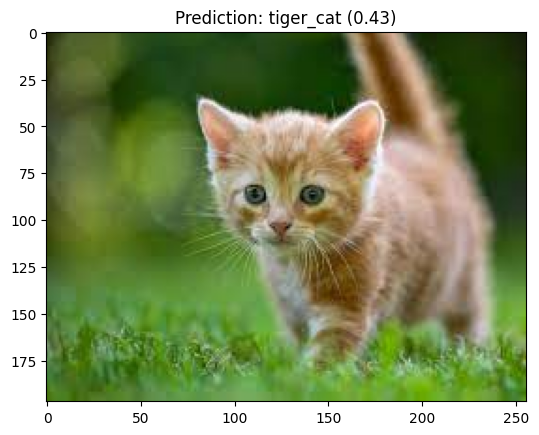

In [12]:
# Example usage
image_path = 'cat.jpg'  # Replace with the path to your image
class_label, class_id, score = infer_image(image_path)

print(f"Predicted label: {class_label}, Confidence score: {score:.2f}")

# Optionally, display the image and prediction
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Prediction: {class_label} ({score:.2f})")
plt.show()

### 2.2 Tensorflow to ONNX model conversion

In [13]:
import tf2onnx
import onnx

# Convert the TensorFlow model to ONNX
# API documentation: https://github.com/onnx/tensorflow-onnx?tab=readme-ov-file#from_keras-tf-20-and-newer
onnx_model, _ = tf2onnx.convert.from_keras(model,
                                        input_signature=[tf.TensorSpec([None, 224, 224, 3], tf.float32, name="input")])

os.makedirs("./exported_models/tensorflow/", exist_ok=True)
output_path = "./exported_models/tensorflow/resnet50_tf.onnx"

# Save the ONNX model to a file
onnx.save_model(onnx_model, output_path)

print(f"ONNX model has been saved to {output_path}")

I0000 00:00:1737888729.956654  189922 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1737888729.956840  189922 single_machine.cc:361] Starting new session
W0000 00:00:1737888729.957321  189922 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
I0000 00:00:1737888732.632090  189922 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1737888732.632495  189922 single_machine.cc:361] Starting new session
W0000 00:00:1737888732.632831  189922 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at

ONNX model has been saved to ./exported_models/tensorflow/resnet50_tf.onnx


In [14]:
!ls -lrth exported_models/tensorflow

total 98M
-rwxrwxrwx 1 meet meet 98M Jan 26 16:22 resnet50_tf.onnx


In [15]:
import IPython
import netron

port = 6006
netron.start(output_path, port, browse=False)
IPython.display.IFrame(f"http://localhost:{port}", width=1000, height=500)

Stopping http://localhost:6006
Serving './exported_models/tensorflow/resnet50_tf.onnx' at http://localhost:6006


## Step-3. Scikit Learn to ONNX

### 3.1 Scikit learn model training and execution

In [16]:
# Installing scikit-learn dependencies
!pip install scikit-learn skl2onnx

  Using cached protobuf-3.20.2-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


Accuracy of the Decision Tree Classifier: 1.00


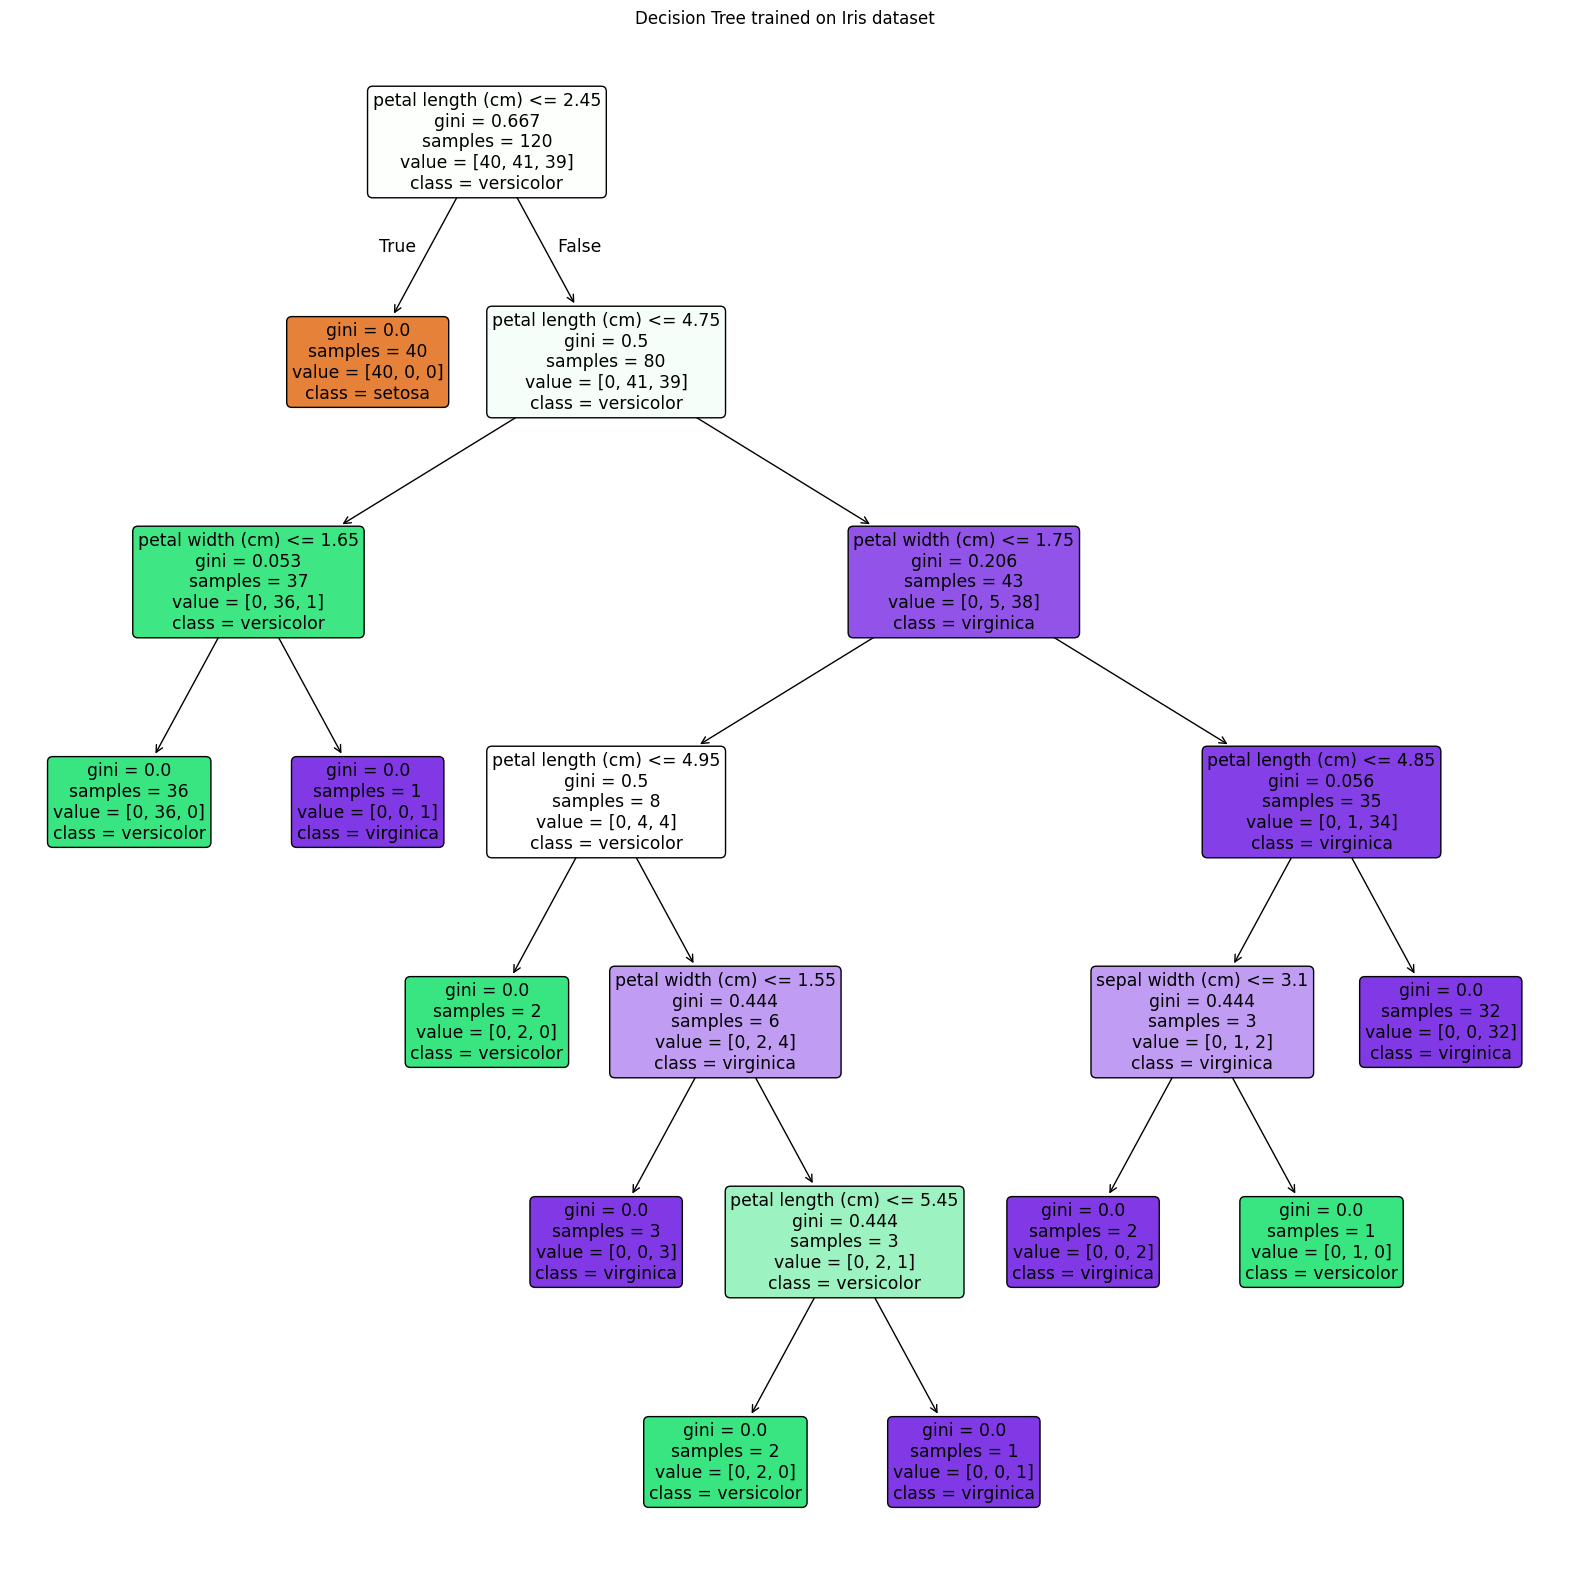

In [17]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features (sepal length, sepal width, petal length, petal width)
y = iris.target  # Target (species)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier model
clf = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Decision Tree Classifier: {accuracy:.2f}")

# Plot the Decision Tree
plt.figure(figsize=(20, 20))
plot_tree(clf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names, rounded=True, proportion=False)
plt.title("Decision Tree trained on Iris dataset")
plt.show()

### 3.2 Scikit-Learn to ONNX model conversion

In [18]:
# Convert into ONNX format.
from skl2onnx import to_onnx

os.makedirs("./exported_models/sklearn/", exist_ok=True)
output_path = "./exported_models/sklearn/decision_tree_sklearn.onnx"

onnx_model = to_onnx(clf, X[:1])
with open(output_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [19]:
!ls -lrth exported_models/sklearn/

total 4.0K
-rwxrwxrwx 1 meet meet 1.7K Jan 26 16:23 decision_tree_sklearn.onnx


In [20]:
import IPython
import netron

port = 6006
netron.start(output_path, port, browse=False)
IPython.display.IFrame(f"http://localhost:{port}", width=1000, height=500)

Stopping http://localhost:6006
Serving './exported_models/sklearn/decision_tree_sklearn.onnx' at http://localhost:6006
